In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for CNN
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# CNN Model (TensorFlow/Keras)
def create_cnn_model(trial):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 256),
                     kernel_size=trial.suggest_int('kernel_size', 2, 5),
                     activation='relu',
                     input_shape=(X_train_scaled.shape[1], 1)))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(trial.suggest_int('dense_units', 32, 256), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout', 0.1, 0.5)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def objective_cnn(trial):
    model = create_cnn_model(trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train,
                        epochs=100,
                        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=0)
    return model.evaluate(X_test_reshaped, y_test, verbose=0)[1]  # Return accuracy

# NovelPCNN Model (PyTorch)
class NovelPCNN(nn.Module):
    def __init__(self, num_filters1, num_filters2, kernel_size1, kernel_size2, fc_neurons):
        super(NovelPCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=num_filters1, kernel_size=kernel_size1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=kernel_size2, padding=1)
        self.fc_neurons = fc_neurons
        self.fc1 = None
        self.fc2 = nn.Linear(fc_neurons, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), self.fc_neurons)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def objective_novelpcnn(trial):
    num_filters1 = trial.suggest_int('num_filters1', 32, 128, step=32)
    num_filters2 = trial.suggest_int('num_filters2', 32, 128, step=32)
    kernel_size1 = trial.suggest_int('kernel_size1', 1, 3)
    kernel_size2 = trial.suggest_int('kernel_size2', 1, 3)
    fc_neurons = trial.suggest_int('fc_neurons', 50, 200, step=50)
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-2)

    model = NovelPCNN(num_filters1, num_filters2, kernel_size1, kernel_size2, fc_neurons)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.tensor(X_train_scaled.reshape(X_train_scaled.shape[0], 22, 1), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled.reshape(X_test_scaled.shape[0], 22, 1), dtype=torch.float32)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred = (y_pred > 0.5).float()
    return accuracy_score(y_test, y_pred.numpy())

# Traditional ML Models
def objective_svm(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    
    model = SVC(C=C, gamma=gamma, kernel=kernel)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 16)
    
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

def objective_xgb(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    
    model = xgb.XGBClassifier(**param, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

# Additional Models
def objective_adaboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                       max_depth=max_depth, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)





[I 2024-10-14 18:23:02,959] A new study created in memory with name: no-name-63186abd-1f68-4c88-8915-80fc0ed8efbd
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)),
[I 2024-10-14 18:23:04,310] Trial 0 finished with value: 0.8974359035491943 and parameters: {'filters': 80, 'kernel_size': 4, 'dense_units': 230, 'dr


CNN Best Hyperparameters: {'filters': 201, 'kernel_size': 4, 'dense_units': 40, 'dropout': 0.31343223905400464, 'learning_rate': 0.0011301549049182566, 'batch_size': 64}
CNN Best Accuracy: 0.9231


[I 2024-10-14 18:23:51,144] Trial 0 finished with value: 0.9487179487179487 and parameters: {'num_filters1': 128, 'num_filters2': 96, 'kernel_size1': 3, 'kernel_size2': 3, 'fc_neurons': 50, 'lr': 0.0033957611704133646}. Best is trial 0 with value: 0.9487179487179487.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2024-10-14 18:23:51,465] Trial 1 finished with value: 0.8205128205128205 and parameters: {'num_filters1': 64, 'num_filters2': 64, 'kernel_size1': 3, 'kernel_size2': 3, 'fc_neurons': 200, 'lr': 0.00016571232308876374}. Best is trial 0 with value: 0.9487179487179487.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:95: FutureWarning: suggest_loguniform


NovelPCNN Best Hyperparameters: {'num_filters1': 128, 'num_filters2': 96, 'kernel_size1': 3, 'kernel_size2': 3, 'fc_neurons': 50, 'lr': 0.0033957611704133646}
NovelPCNN Best Accuracy: 0.9487


[I 2024-10-14 18:24:14,936] Trial 21 finished with value: 0.8974358974358975 and parameters: {'C': 812.882749881769, 'gamma': 0.6941900013007415, 'kernel': 'linear'}. Best is trial 0 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:121: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:122: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
[I 2024-10-14 18:24:14,966] Trial 22 finished with value: 0.9230769230769231 and parameters: {'C': 177.0411


SVM Best Hyperparameters: {'C': 0.1792843011046604, 'gamma': 0.0012759662222374063, 'kernel': 'linear'}
SVM Best Accuracy: 0.9231


[I 2024-10-14 18:24:15,543] Trial 0 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 812, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8974358974358975.
[I 2024-10-14 18:24:15,741] Trial 1 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 556, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8974358974358975.
[I 2024-10-14 18:24:16,065] Trial 2 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 882, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9487179487179487.
[I 2024-10-14 18:24:16,183] Trial 3 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 326, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 16}. Best is trial 2 with value: 0.9487179487179487.
[I 2024-10-14 18:24:16,423] Trial 4 finished with value: 0.8974358974358975 and parameters:


Random Forest Best Hyperparameters: {'n_estimators': 882, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 6}
Random Forest Best Accuracy: 0.9487


[I 2024-10-14 18:24:28,646] Trial 13 finished with value: 0.9487179487179487 and parameters: {'max_depth': 6, 'learning_rate': 0.08866638314432135, 'n_estimators': 403, 'min_child_weight': 4, 'subsample': 0.9965775379245936, 'colsample_bytree': 0.8515642202792164}. Best is trial 7 with value: 0.9487179487179487.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:146: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:149: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 


XGBoost Best Hyperparameters: {'max_depth': 2, 'learning_rate': 0.18062850347972992, 'n_estimators': 315, 'min_child_weight': 2, 'subsample': 0.9299090416729245, 'colsample_bytree': 0.8987205246446331}
XGBoost Best Accuracy: 0.9487


[I 2024-10-14 18:24:30,110] Trial 0 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 425, 'learning_rate': 0.0023236843445817714}. Best is trial 0 with value: 0.8974358974358975.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:161: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2024-10-14 18:24:30,157] Trial 1 finished with value: 0.8461538461538461 and parameters: {'n_estimators': 83, 'learning_rate': 0.2573571793659773}. Best is trial 0 with value: 0.897435897


AdaBoost Best Hyperparameters: {'n_estimators': 104, 'learning_rate': 0.0012539511989295268}
AdaBoost Best Accuracy: 0.9231


[I 2024-10-14 18:24:35,566] Trial 34 finished with value: 0.9230769230769231 and parameters: {'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 12}. Best is trial 4 with value: 0.9487179487179487.
[I 2024-10-14 18:24:35,573] Trial 35 finished with value: 0.9487179487179487 and parameters: {'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.9487179487179487.
[I 2024-10-14 18:24:35,579] Trial 36 finished with value: 0.9487179487179487 and parameters: {'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.9487179487179487.
[I 2024-10-14 18:24:35,586] Trial 37 finished with value: 0.9230769230769231 and parameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.9487179487179487.
[I 2024-10-14 18:24:35,592] Trial 38 finished with value: 0.9230769230769231 and parameters: {'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is tr


Decision Tree Best Hyperparameters: {'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 8}
Decision Tree Best Accuracy: 0.9487


[I 2024-10-14 18:24:35,969] Trial 1 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 267, 'learning_rate': 0.048593861657421814, 'max_depth': 7}. Best is trial 0 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:181: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
[I 2024-10-14 18:24:36,137] Trial 2 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 251, 'learning_rate': 0.07618846953864811, 'max_depth': 16}. Best is trial 0 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:181: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu


Gradient Boosting Best Hyperparameters: {'n_estimators': 172, 'learning_rate': 0.13274115448618629, 'max_depth': 2}
Gradient Boosting Best Accuracy: 0.9487


[I 2024-10-14 18:24:42,193] Trial 11 finished with value: 0.9743589743589743 and parameters: {'n_neighbors': 1, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:24:42,203] Trial 12 finished with value: 0.9743589743589743 and parameters: {'n_neighbors': 1, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:24:42,221] Trial 13 finished with value: 0.9487179487179487 and parameters: {'n_neighbors': 6, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:24:42,248] Trial 14 finished with value: 0.9487179487179487 and parameters: {'n_neighbors': 4, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:24:42,277] Trial 15 finished with value: 0.9487179487179487 and parameters: {'n_neighbors': 4, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:24:42,306] Trial 16 finished with value: 0.9230769230769231 and


KNN Best Hyperparameters: {'n_neighbors': 2, 'weights': 'distance'}
KNN Best Accuracy: 0.9744


TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'n_neighbors'

In [4]:




# Optimize and evaluate all models
models = {
    'CNN': objective_cnn,
    'NovelPCNN': objective_novelpcnn,
    'SVM': objective_svm,
    'Random Forest': objective_rf,
    'XGBoost': objective_xgb,
    'AdaBoost': objective_adaboost,
    'Decision Tree': objective_dt,
    'Gradient Boosting': objective_gb,
    'KNN': objective_knn
}

results = {}
best_params = {}

for name, objective in models.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    print(f"\n{name} Best Hyperparameters: {study.best_params}")
    print(f"{name} Best Accuracy: {study.best_value:.4f}")
    results[name] = study.best_value
    best_params[name] = study.best_params

# Ensemble Model
best_models = {
    'AdaBoost': AdaBoostClassifier(**best_params['AdaBoost'], random_state=42),
    'KNN': KNeighborsClassifier(**best_params['KNN']),
    'XGBoost': xgb.XGBClassifier(**best_params['XGBoost'], random_state=42)
}

ensemble_model = VotingClassifier(estimators=[(name, model) for name, model in best_models.items()], voting='soft')
ensemble_model.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble_model.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
results['Ensemble'] = ensemble_accuracy

print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble))







# Final Results
print("\nFinal Results:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")

print("\nBest performing model:")
best_model = max(results, key=results.get)
print(f"{best_model} with accuracy: {results[best_model]:.4f}")

# Create and display the comparison table
comparison_data = []
for name, accuracy in results.items():
    if name == 'Ensemble':
        y_pred = y_pred_ensemble
    elif name == 'CNN':
        y_pred = (create_cnn_model(study).predict(X_test_reshaped) > 0.5).astype(int)
    elif name == 'NovelPCNN':
        model = NovelPCNN(**study.best_params)
        X_test_tensor = torch.tensor(X_test_scaled.reshape(X_test_scaled.shape[0], 22, 1), dtype=torch.float32)
        y_pred = (model(X_test_tensor) > 0.5).float().numpy()
    else:
        y_pred = best_models[name].predict(X_test_scaled) if name in best_models else None
    
    if y_pred is not None:
        report = classification_report(y_test, y_pred, output_dict=True)
        comparison_data.append({
            'Model': name,
            'Accuracy (%)': accuracy * 100,
            'Precision (Class 0)': report['0']['precision'],
            'Precision (Class 1)': report['1']['precision'],
            'Recall (Class 0)': report['0']['recall'],
            'Recall (Class 1)': report['1']['recall'],
            'F1-Score (Class 0)': report['0']['f1-score'],
            'F1-Score (Class 1)': report['1']['f1-score']
        })

comparison_table = pd.DataFrame(comparison_data)
comparison_table = comparison_table.sort_values('Accuracy (%)', ascending=False)
comparison_table = comparison_table.reset_index(drop=True)

print("\nComparison Table:")
print(comparison_table.to_string(index=False))

# Save results to CSV
comparison_table.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv'")


[I 2024-10-14 18:39:47,436] A new study created in memory with name: no-name-c645a997-58d3-437e-9853-086f695fd2ce
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)),
[I 2024-10-14 18:39:48,071] Trial 0 finished with value: 0.8461538553237915 and parameters: {'filters': 167, 'kernel_size': 2, 'dense_units': 153, 'd


CNN Best Hyperparameters: {'filters': 121, 'kernel_size': 4, 'dense_units': 73, 'dropout': 0.3411559918200767, 'learning_rate': 0.0028488222094944582, 'batch_size': 32}
CNN Best Accuracy: 0.9231


[I 2024-10-14 18:40:39,234] Trial 0 finished with value: 0.8205128205128205 and parameters: {'num_filters1': 64, 'num_filters2': 32, 'kernel_size1': 2, 'kernel_size2': 2, 'fc_neurons': 50, 'lr': 8.927226838108596e-05}. Best is trial 0 with value: 0.8205128205128205.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2024-10-14 18:40:39,556] Trial 1 finished with value: 0.8717948717948718 and parameters: {'num_filters1': 128, 'num_filters2': 32, 'kernel_size1': 1, 'kernel_size2': 2, 'fc_neurons': 50, 'lr': 0.0003837683460382215}. Best is trial 1 with value: 0.8717948717948718.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:95: FutureWarning: suggest_loguniform h


NovelPCNN Best Hyperparameters: {'num_filters1': 64, 'num_filters2': 64, 'kernel_size1': 2, 'kernel_size2': 1, 'fc_neurons': 50, 'lr': 0.0030412069580058694}
NovelPCNN Best Accuracy: 0.9487


[I 2024-10-14 18:40:59,259] Trial 17 finished with value: 0.9230769230769231 and parameters: {'C': 69.93539498879827, 'gamma': 0.0010351231821274203, 'kernel': 'linear'}. Best is trial 2 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:121: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:122: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
[I 2024-10-14 18:40:59,263] Trial 18 finished with value: 0.8205128205128205 and parameters: {'C': 0.20


SVM Best Hyperparameters: {'C': 17.48688964429502, 'gamma': 0.040472488881238604, 'kernel': 'rbf'}
SVM Best Accuracy: 0.9487


[I 2024-10-14 18:41:00,056] Trial 0 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 793, 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8974358974358975.
[I 2024-10-14 18:41:00,211] Trial 1 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 409, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.8974358974358975.
[I 2024-10-14 18:41:00,284] Trial 2 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 185, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.8974358974358975.
[I 2024-10-14 18:41:00,354] Trial 3 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 174, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.8974358974358975.
[I 2024-10-14 18:41:00,456] Trial 4 finished with value: 0.8974358974358975 and parameter


Random Forest Best Hyperparameters: {'n_estimators': 648, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 2}
Random Forest Best Accuracy: 0.9487


[I 2024-10-14 18:41:13,451] Trial 12 finished with value: 0.9487179487179487 and parameters: {'max_depth': 3, 'learning_rate': 0.007806283597859292, 'n_estimators': 390, 'min_child_weight': 2, 'subsample': 0.5065654114987947, 'colsample_bytree': 0.9058218598152156}. Best is trial 9 with value: 0.9487179487179487.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:146: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:149: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,


XGBoost Best Hyperparameters: {'max_depth': 3, 'learning_rate': 0.04670149389602081, 'n_estimators': 459, 'min_child_weight': 4, 'subsample': 0.5449888668331024, 'colsample_bytree': 0.9902720885328786}
XGBoost Best Accuracy: 0.9487


[I 2024-10-14 18:41:15,013] Trial 2 finished with value: 0.8461538461538461 and parameters: {'n_estimators': 253, 'learning_rate': 0.9133356881620655}. Best is trial 1 with value: 0.8974358974358975.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:161: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2024-10-14 18:41:15,171] Trial 3 finished with value: 0.8205128205128205 and parameters: {'n_estimators': 296, 'learning_rate': 0.21408467365072242}. Best is trial 1 with value: 0.8974358974


AdaBoost Best Hyperparameters: {'n_estimators': 148, 'learning_rate': 0.001062369145040457}
AdaBoost Best Accuracy: 0.9231


[I 2024-10-14 18:41:20,260] Trial 35 finished with value: 0.9487179487179487 and parameters: {'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 18:41:20,267] Trial 36 finished with value: 0.9487179487179487 and parameters: {'max_depth': 25, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 18:41:20,274] Trial 37 finished with value: 0.8974358974358975 and parameters: {'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 18:41:20,286] Trial 38 finished with value: 0.9230769230769231 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 18:41:20,293] Trial 39 finished with value: 0.8974358974358975 and parameters: {'max_depth': 31, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is 


Decision Tree Best Hyperparameters: {'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 6}
Decision Tree Best Accuracy: 0.9487


[I 2024-10-14 18:41:20,574] Trial 0 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 317, 'learning_rate': 0.010707686891354285, 'max_depth': 23}. Best is trial 0 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:181: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
[I 2024-10-14 18:41:20,644] Trial 1 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 105, 'learning_rate': 0.16377763389755068, 'max_depth': 5}. Best is trial 0 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3723886588.py:181: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu


Gradient Boosting Best Hyperparameters: {'n_estimators': 428, 'learning_rate': 0.03128437430970132, 'max_depth': 3}
Gradient Boosting Best Accuracy: 0.9487


[I 2024-10-14 18:41:28,785] Trial 39 finished with value: 0.9743589743589743 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:41:28,793] Trial 40 finished with value: 0.9230769230769231 and parameters: {'n_neighbors': 10, 'weights': 'uniform'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:41:28,799] Trial 41 finished with value: 0.9743589743589743 and parameters: {'n_neighbors': 1, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:41:28,803] Trial 42 finished with value: 0.9743589743589743 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:41:28,808] Trial 43 finished with value: 0.9487179487179487 and parameters: {'n_neighbors': 4, 'weights': 'distance'}. Best is trial 7 with value: 0.9743589743589743.
[I 2024-10-14 18:41:28,812] Trial 44 finished with value: 0.9743589743589743 and


KNN Best Hyperparameters: {'n_neighbors': 1, 'weights': 'uniform'}
KNN Best Accuracy: 0.9744

Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39


Final Results:
CNN: 0.9231
NovelPCNN: 0.9487
SVM: 0.9487
Random Forest: 0.9487
XGBoost: 0.9487
AdaBoost: 0.9231
Decision Tree: 0.9487
Gradient Boosting: 0.9487
KNN: 0.9744
Ensemble: 0.9487

Best performing model:
KNN with accuracy: 0.9744


AttributeError: 'Study' object has no attribute 'suggest_int'

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import shap

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for CNN
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

def create_model(trial):
    n_conv_layers = trial.suggest_int('n_conv_layers', 1, 3)
    n_dense_layers = trial.suggest_int('n_dense_layers', 1, 3)
    
    model = Sequential()
    
    # Input layer
    model.add(Conv1D(filters=trial.suggest_int('filters_1', 32, 256),
                     kernel_size=trial.suggest_int('kernel_1', 2, 5),
                     activation='relu',
                     input_shape=(X_train_scaled.shape[1], 1)))
    
    # Additional Conv1D layers
    for i in range(n_conv_layers - 1):
        model.add(Conv1D(filters=trial.suggest_int(f'filters_{i+2}', 32, 256),
                         kernel_size=trial.suggest_int(f'kernel_{i+2}', 2, 5),
                         activation='relu'))
    
    # Global Average Pooling
    model.add(GlobalAveragePooling1D())
    
    # Dense layers
    for i in range(n_dense_layers):
        model.add(Dense(trial.suggest_int(f'dense_units_{i+1}', 32, 256),
                        activation='relu',
                        kernel_regularizer=l2(trial.suggest_loguniform('l2', 1e-5, 1e-2))))
        model.add(Dropout(trial.suggest_float(f'dropout_{i+1}', 0.1, 0.5)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(trial):
    model = create_model(trial)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    
    history = model.fit(X_train_reshaped, y_train,
                        epochs=150,
                        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
                        validation_split=0.2,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
    return accuracy

# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

# Get the best model
best_model = create_model(study.best_trial)

# Implement k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    X_train_fold_reshaped = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_val_fold_reshaped = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))
    
    best_model.fit(X_train_fold_reshaped, y_train_fold,
                   epochs=150,
                   batch_size=study.best_params['batch_size'],
                   validation_data=(X_val_fold_reshaped, y_val_fold),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)],
                   verbose=0)
    
    # Evaluate the model
    loss, accuracy = best_model.evaluate(X_val_fold_reshaped, y_val_fold, verbose=0)
    cv_scores.append(accuracy)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")

print(f"\nMean CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Evaluate the best model on the test set
y_pred = (best_model.predict(X_test_reshaped) > 0.5).astype(int)
y_pred_proba = best_model.predict(X_test_reshaped)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

print(f"\nTest Set Results:")
print(f"Best Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nBest Hyperparameters:")
print(study.best_params)


[I 2024-10-14 19:00:17,943] A new study created in memory with name: no-name-d1920318-9ba3-4bf1-92fd-a605bb01b9d8
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/1442076688.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  kernel_regularizer=l2(trial.suggest_loguniform('l2', 1e-5, 1e-2))))
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/1442076688.py:67: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v

Fold 1 Accuracy: 1.0000
Fold 2 Accuracy: 0.9677
Fold 3 Accuracy: 1.0000
Fold 4 Accuracy: 1.0000
Fold 5 Accuracy: 1.0000

Mean CV Accuracy: 0.9935 (+/- 0.0129)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Test Set Results:
Best Accuracy: 0.9231
ROC AUC: 0.9690
PR AUC: 0.9895

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39


Best Hyperparameters:
{'n_conv_layers': 3, 'n_dense_layers': 2, 'filters_1': 91, 'kernel_1': 3, 'filters_2': 92, 'kernel_2': 4, 'filters_3': 182, 'kernel_3': 5, 'dense_units_1': 174, 'l2': 5.6317044074994335e-05, 'dropout_1': 0.1305071106946792, 'dense_units_2': 151, 'dropout_2': 0.1532463662541964, 'learning_rate': 0.008264335904107672, 'b

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")



Feature Importance Analysis:


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

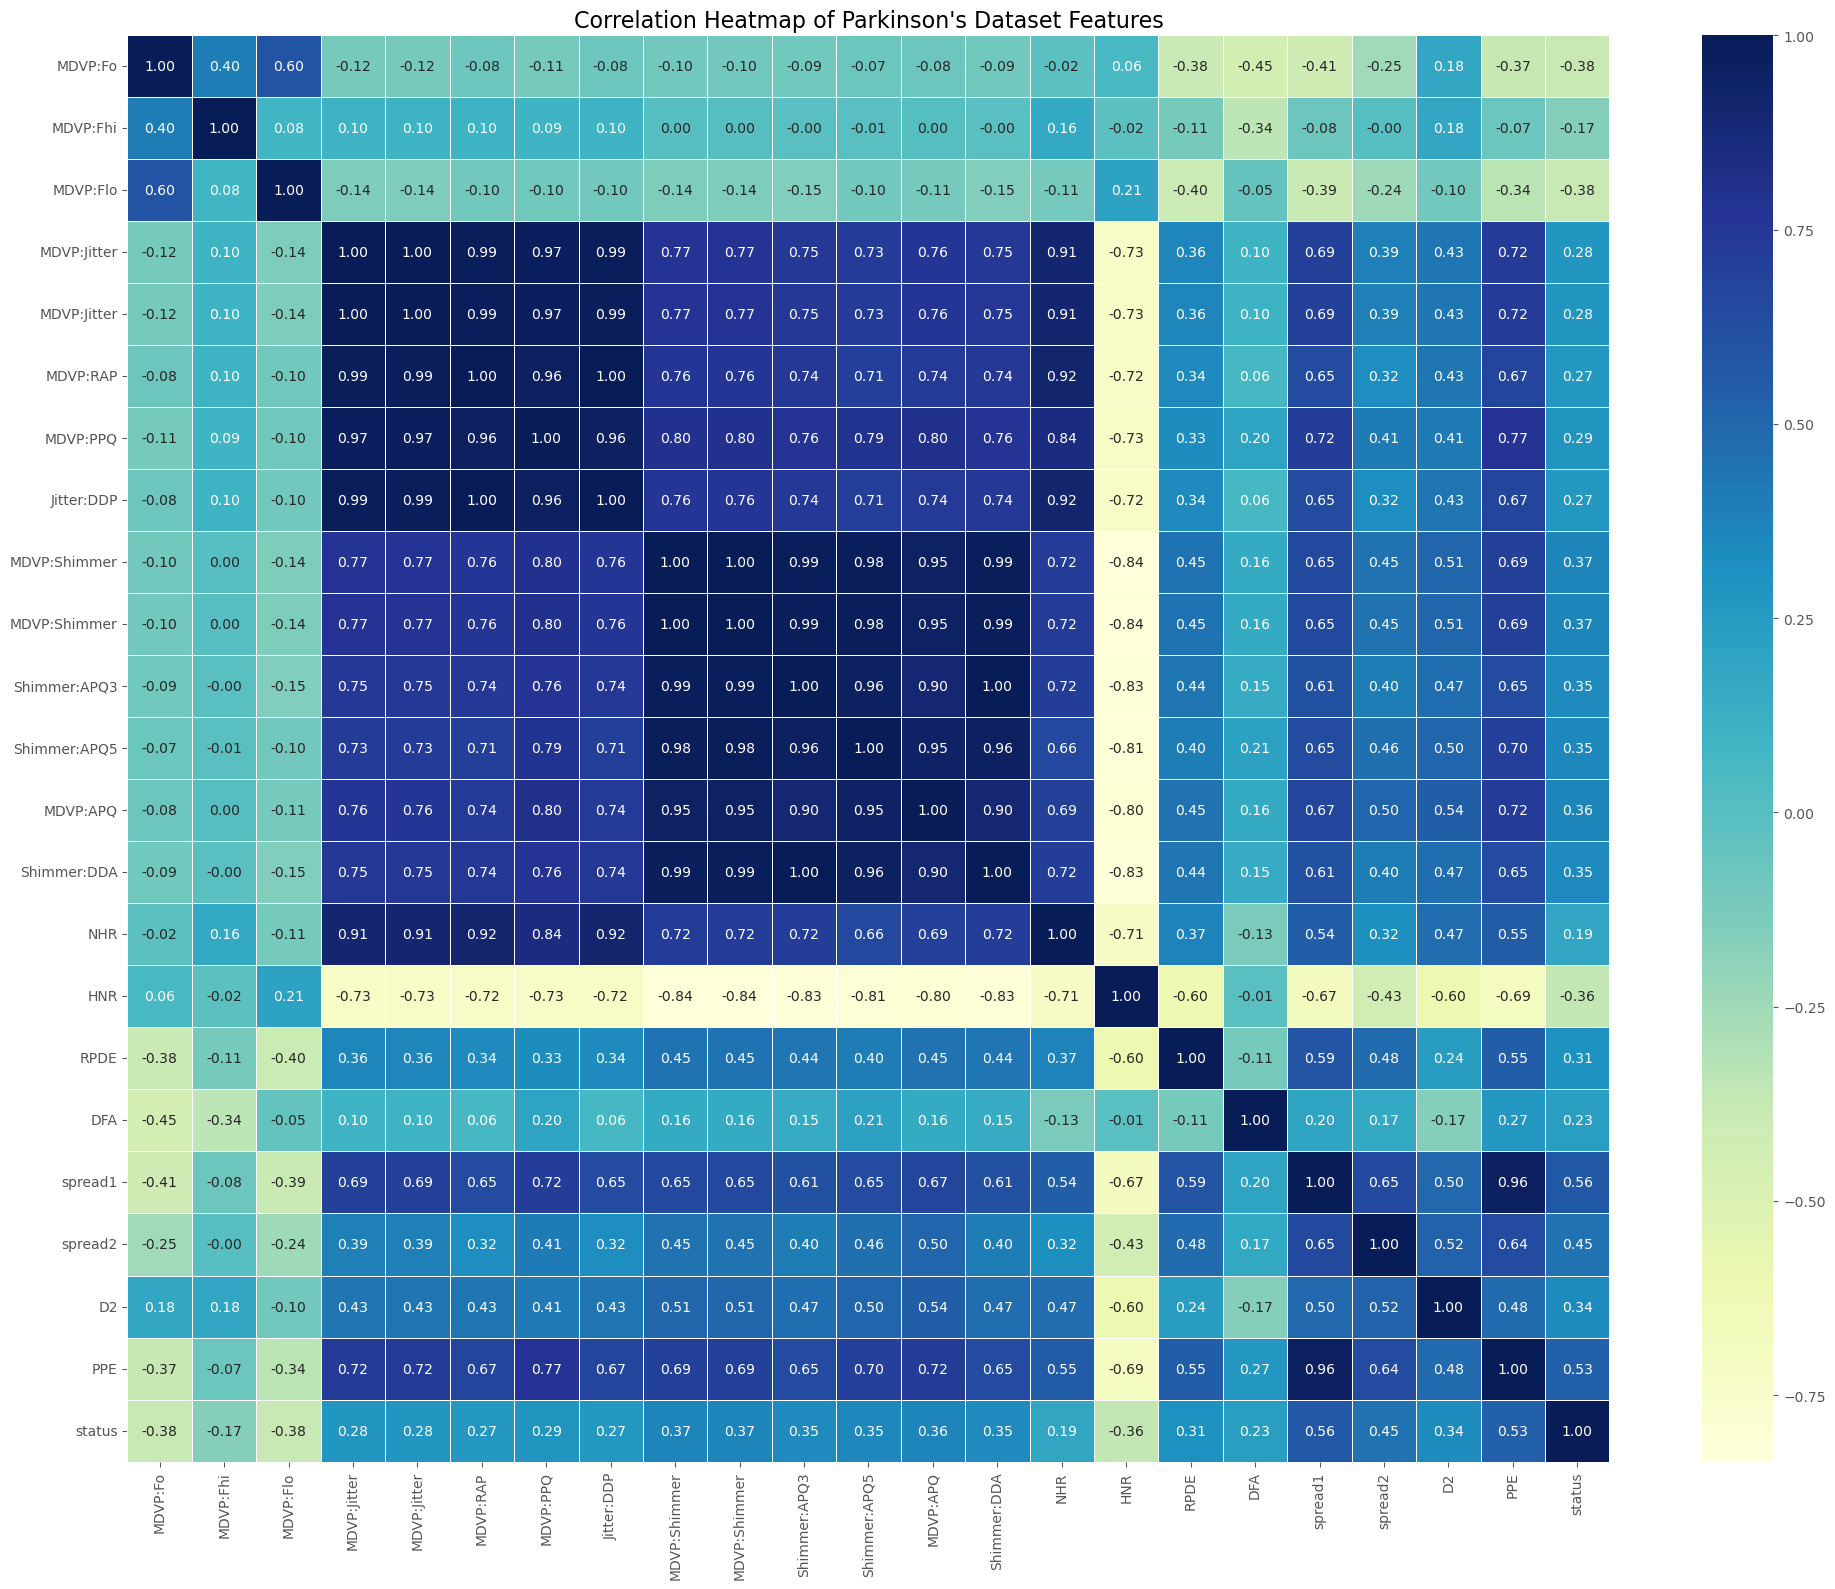

Correlation heatmap has been generated, saved, and displayed.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Fetch the dataset
parkinsons = fetch_ucirepo(id=174)
X = parkinsons.data.features
y = parkinsons.data.targets

# Combine features and target
df = pd.concat([X, y], axis=1)

# Set the style for all plots
plt.style.use('ggplot')
sns.set_palette("Set2")

# Correlation Heatmap
plt.figure(figsize=(20, 16))  # Increased figure size for better readability
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5, cbar=True)
plt.title('Correlation Heatmap of Parkinson\'s Dataset Features', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Correlation heatmap has been generated, saved, and displayed.")

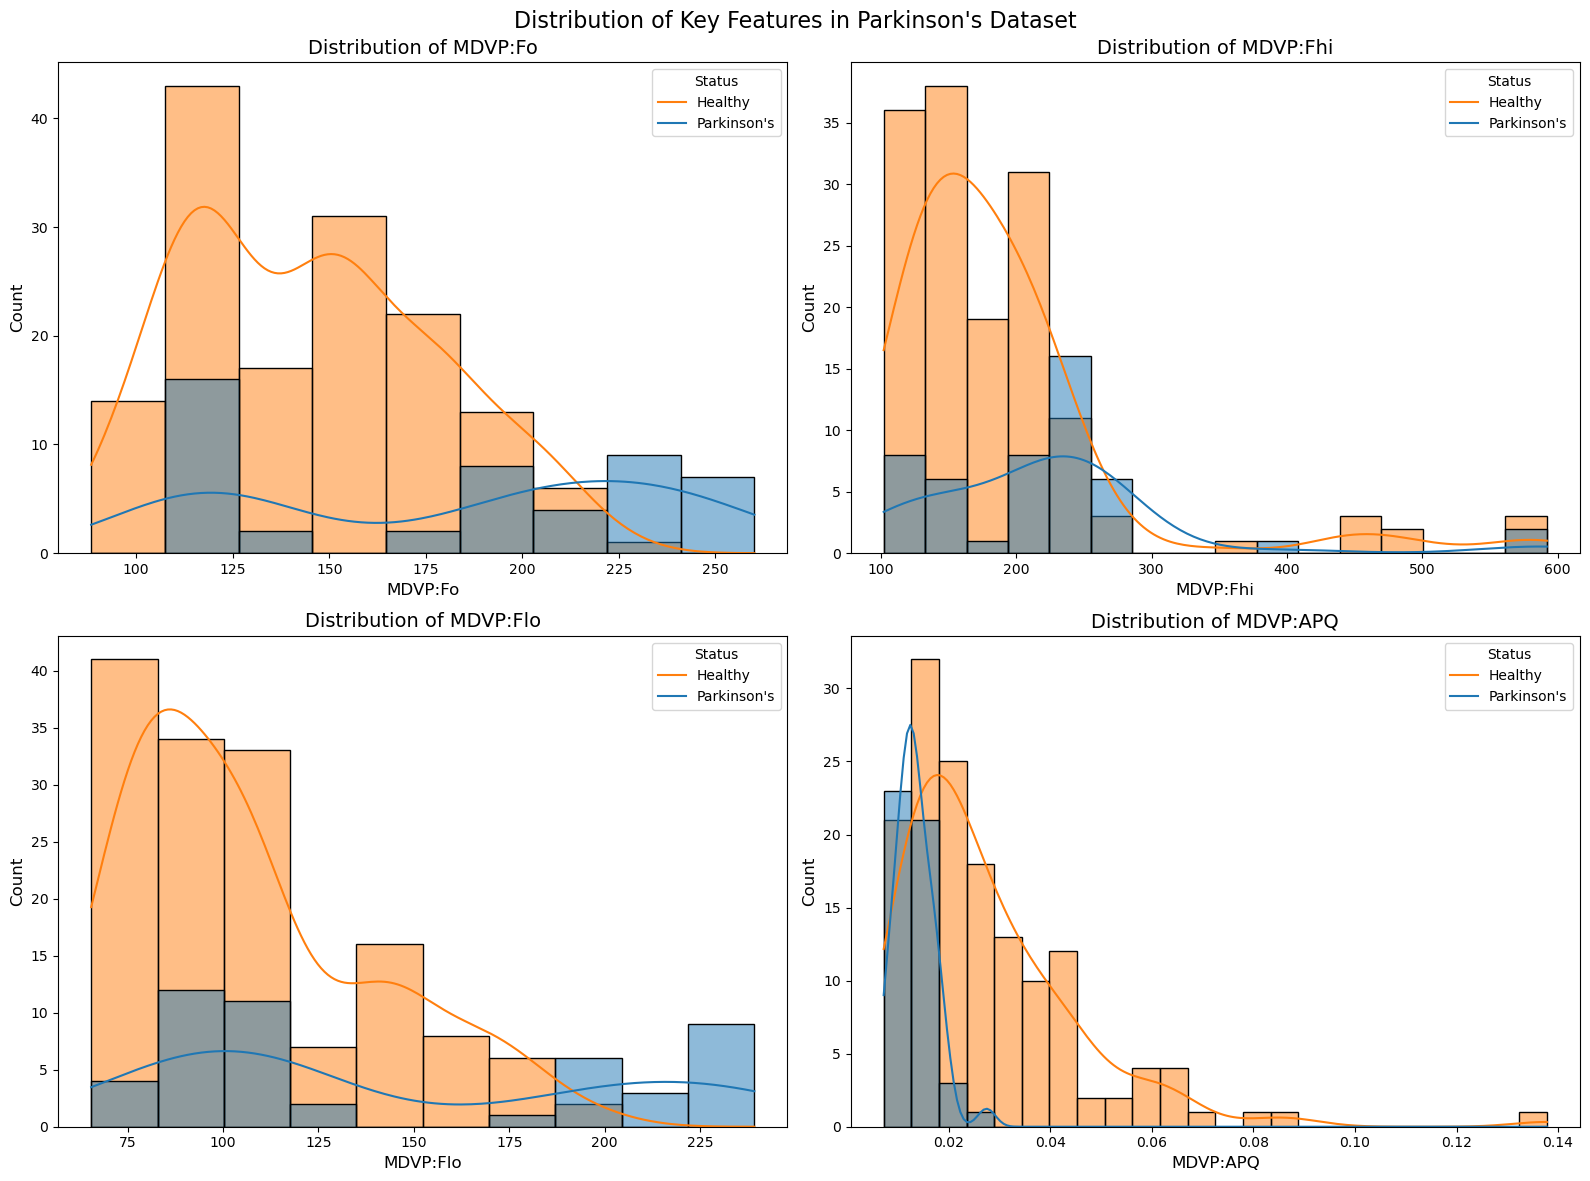

Visualizations have been generated, saved, and displayed.


In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Fetch the Parkinson's dataset
parkinsons = fetch_ucirepo(id=174)
X = parkinsons.data.features
y = parkinsons.data.targets

# Convert y to a 1D series
y = y['status'].squeeze()

# Combine features and target
df = pd.concat([X, pd.Series(y, name='status')], axis=1)

# Set up the plot style
plt.style.use('default')

# Visualize Distribution of Key Numerical Features
key_features = ['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:APQ']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Key Features in Parkinson\'s Dataset', fontsize=16)

for i, feature in enumerate(key_features):
    row = i // 2
    col = i % 2
    
    sns.histplot(data=df, x=feature, hue='status', kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}', fontsize=14)
    axes[row, col].set_xlabel(feature, fontsize=12)
    axes[row, col].set_ylabel('Count', fontsize=12)
    axes[row, col].legend(title='Status', labels=['Healthy', 'Parkinson\'s'])

plt.tight_layout()
plt.savefig('key_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations have been generated, saved, and displayed.")


/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/2253497728.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette=colors)


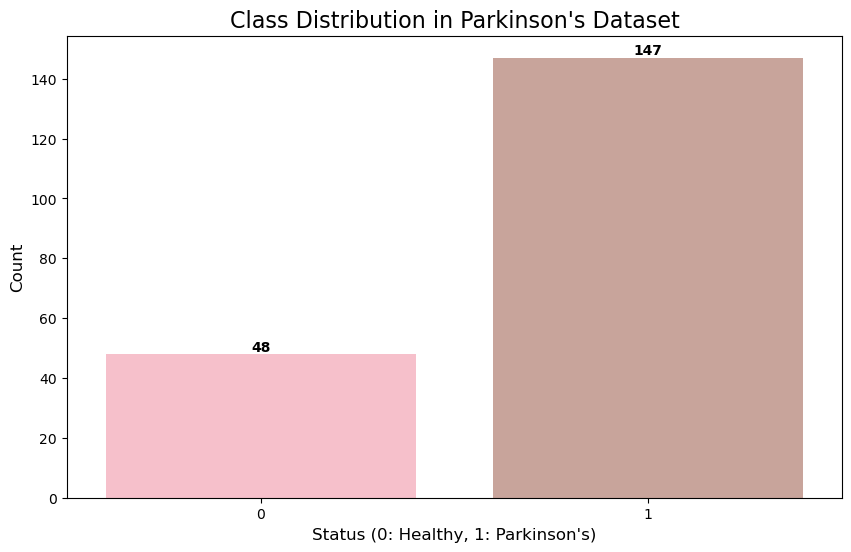

Class distribution plot has been generated, saved, and displayed.


In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Fetch the Parkinson's dataset
parkinsons = fetch_ucirepo(id=174)
X = parkinsons.data.features
y = parkinsons.data.targets

# Convert y to a 1D series
y = y['status'].squeeze()

# Combine features and target
df = pd.concat([X, pd.Series(y, name='status')], axis=1)

# Set up the plot style
plt.style.use('default')

# 1. Visualize Class Distribution
plt.figure(figsize=(10, 6))
colors = ['#ffb7c5', '#cfa093']  # Light salmon for 0, Light green for 1
sns.countplot(x='status', data=df, palette=colors)
plt.title('Class Distribution in Parkinson\'s Dataset', fontsize=16)
plt.xlabel('Status (0: Healthy, 1: Parkinson\'s)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on top of each bar
for i, count in enumerate(df['status'].value_counts().sort_index()):
    plt.text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Class distribution plot has been generated, saved, and displayed.")


/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/2233913639.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette=colors)


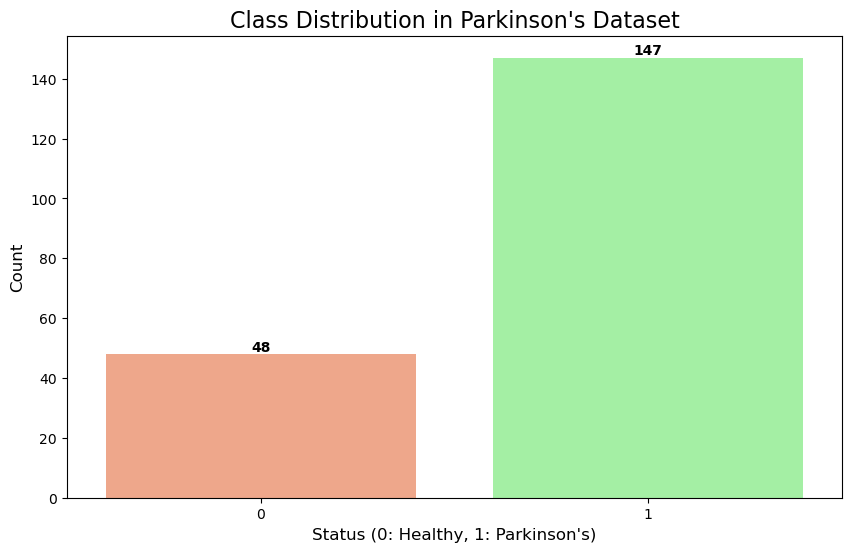

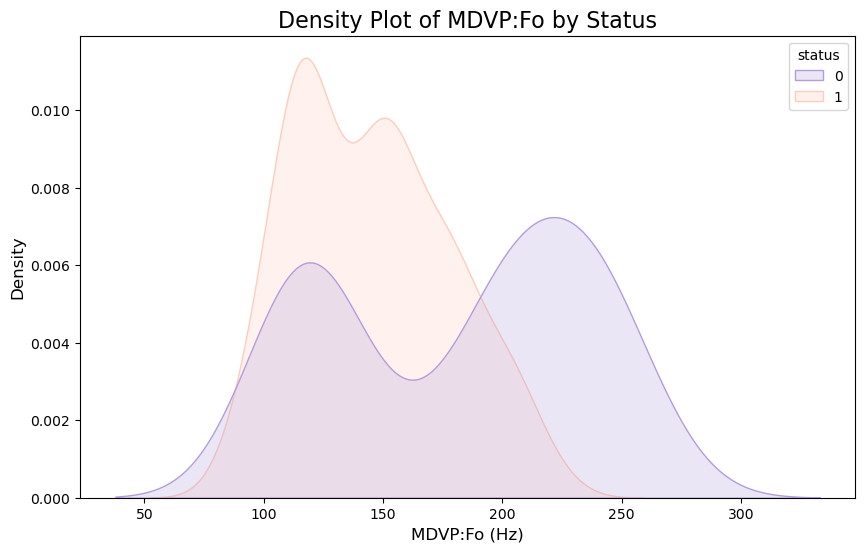

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Fetch the Parkinson's dataset
parkinsons = fetch_ucirepo(id=174)
X = parkinsons.data.features
y = parkinsons.data.targets['status']

# Combine features and target
df = pd.concat([X, y], axis=1)

# Visualize Class Distribution
plt.figure(figsize=(10, 6))
colors = ['#FFA07A', '#98FB98']  # Light salmon for 0, Light green for 1
sns.countplot(x='status', data=df, palette=colors)
plt.title('Class Distribution in Parkinson\'s Dataset', fontsize=16)
plt.xlabel('Status (0: Healthy, 1: Parkinson\'s)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on top of each bar
for i, count in enumerate(df['status'].value_counts().sort_index()):
    plt.text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


# Visualize Density Plot for a Key Feature
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='MDVP:Fo', hue='status', fill=True, common_norm=False, palette=['#B39DDB', '#FFCCBC'])
plt.title('Density Plot of MDVP:Fo by Status', fontsize=16)
plt.xlabel('MDVP:Fo (Hz)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.savefig('density_plot.png', dpi=300, bbox_inches='tight')
plt.show()

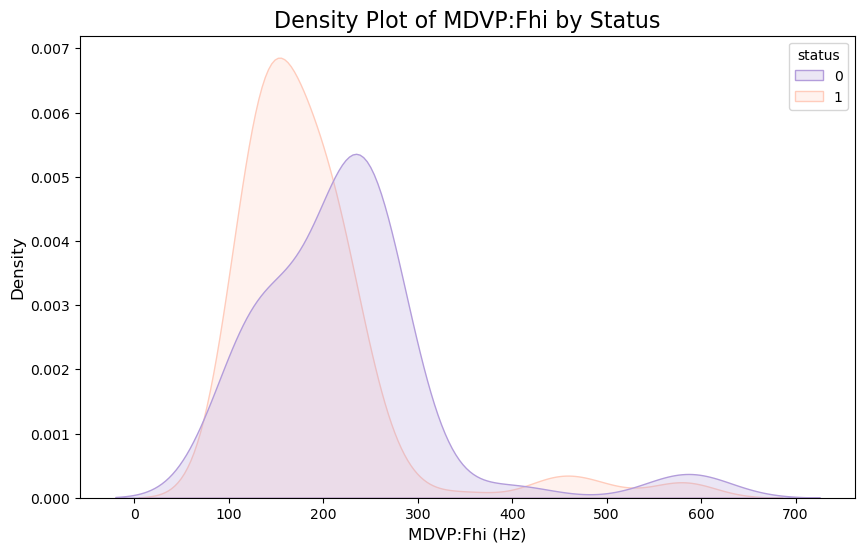

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Fetch the Parkinson's dataset
parkinsons = fetch_ucirepo(id=174)
X = parkinsons.data.features
y = parkinsons.data.targets['status']

# Handle duplicate column names by renaming
X.columns = [f'{col}_{i}' if X.columns.tolist().count(col) > 1 else col 
             for i, col in enumerate(X.columns)]

# Combine features and target
df = pd.concat([X, pd.Series(y, name='status')], axis=1)

# Visualize Density Plot for a Key Feature
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='MDVP:Fhi', hue='status', fill=True, common_norm=False, palette=['#B39DDB', '#FFCCBC'])
plt.title('Density Plot of MDVP:Fhi by Status', fontsize=16)
plt.xlabel('MDVP:Fhi (Hz)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.savefig('density_plot.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3473753608.py:20: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=df, x=feature, hue='status', fill=True, common_norm=False, palette=[color], alpha=0.5, label=feature)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3473753608.py:20: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=df, x=feature, hue='status', fill=True, common_norm=False, palette=[color], alpha=0.5, label=feature)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_9418/3473753608.py:20: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=df, x=feature, hue='status', fill=True, common_norm=False, palette=[color], alpha=0.5, label=feature)


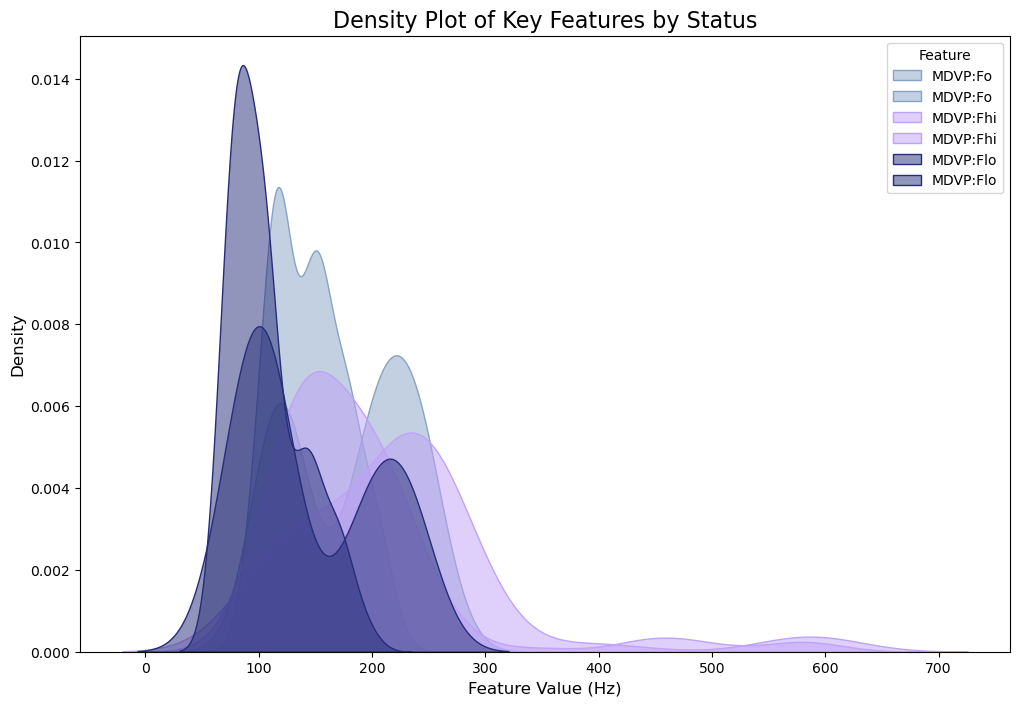

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Fetch the Parkinson's dataset
parkinsons = fetch_ucirepo(id=174)
X = parkinsons.data.features
y = parkinsons.data.targets['status']

# Combine features and target
df = pd.concat([X, pd.Series(y, name='status')], axis=1)

# Visualize Density Plot for Multiple Features
plt.figure(figsize=(12, 8))
features = ['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo']
colors = ['#88a2c4', '#bfa2f9', '#262d79']  # Unique colors for each feature

for feature, color in zip(features, colors):
    sns.kdeplot(data=df, x=feature, hue='status', fill=True, common_norm=False, palette=[color], alpha=0.5, label=feature)

plt.title('Density Plot of Key Features by Status', fontsize=16)
plt.xlabel('Feature Value (Hz)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Feature')
plt.savefig('density_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Sample y_test labels (replace with your actual y_test labels)
y_test = [...]  # Insert actual test labels here

# Predicted probabilities for each model (replace with actual probabilities from each model)
y_pred_proba_svm = [...]                # SVM probabilities
y_pred_proba_decision_tree = [...]       # Decision Tree probabilities
y_pred_proba_knn = [...]                 # KNN probabilities
y_pred_proba_random_forest = [...]       # Random Forest probabilities
y_pred_proba_adaboost = [...]            # AdaBoost probabilities
y_pred_proba_gradient_boosting = [...]   # Gradient Boosting probabilities
y_pred_proba_xgboost = [...]             # XGBoost probabilities
y_pred_proba_cnn = [...]                 # CNN probabilities
y_pred_proba_tabular_transformer = [...] # Tabular Transformer probabilities

# Define a dictionary of model names and their predicted probabilities for easier iteration
models = {
    "SVM": y_pred_proba_svm,
    "Decision Tree": y_pred_proba_decision_tree,
    "KNN": y_pred_proba_knn,
    "Random Forest": y_pred_proba_random_forest,
    "AdaBoost": y_pred_proba_adaboost,
    "Gradient Boosting": y_pred_proba_gradient_boosting,
    "XGBoost": y_pred_proba_xgboost,
    "CNN": y_pred_proba_cnn,
    "Tabular Transformer": y_pred_proba_tabular_transformer
}

# Plot ROC curves for all models
plt.figure(figsize=(12, 10))
for model_name, y_pred_proba in models.items():
    # Calculate False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")

# Plot the diagonal reference line for a random classifier
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

# Set labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve Comparison for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


ValueError: unknown format is not supported

<Figure size 1200x1000 with 0 Axes>

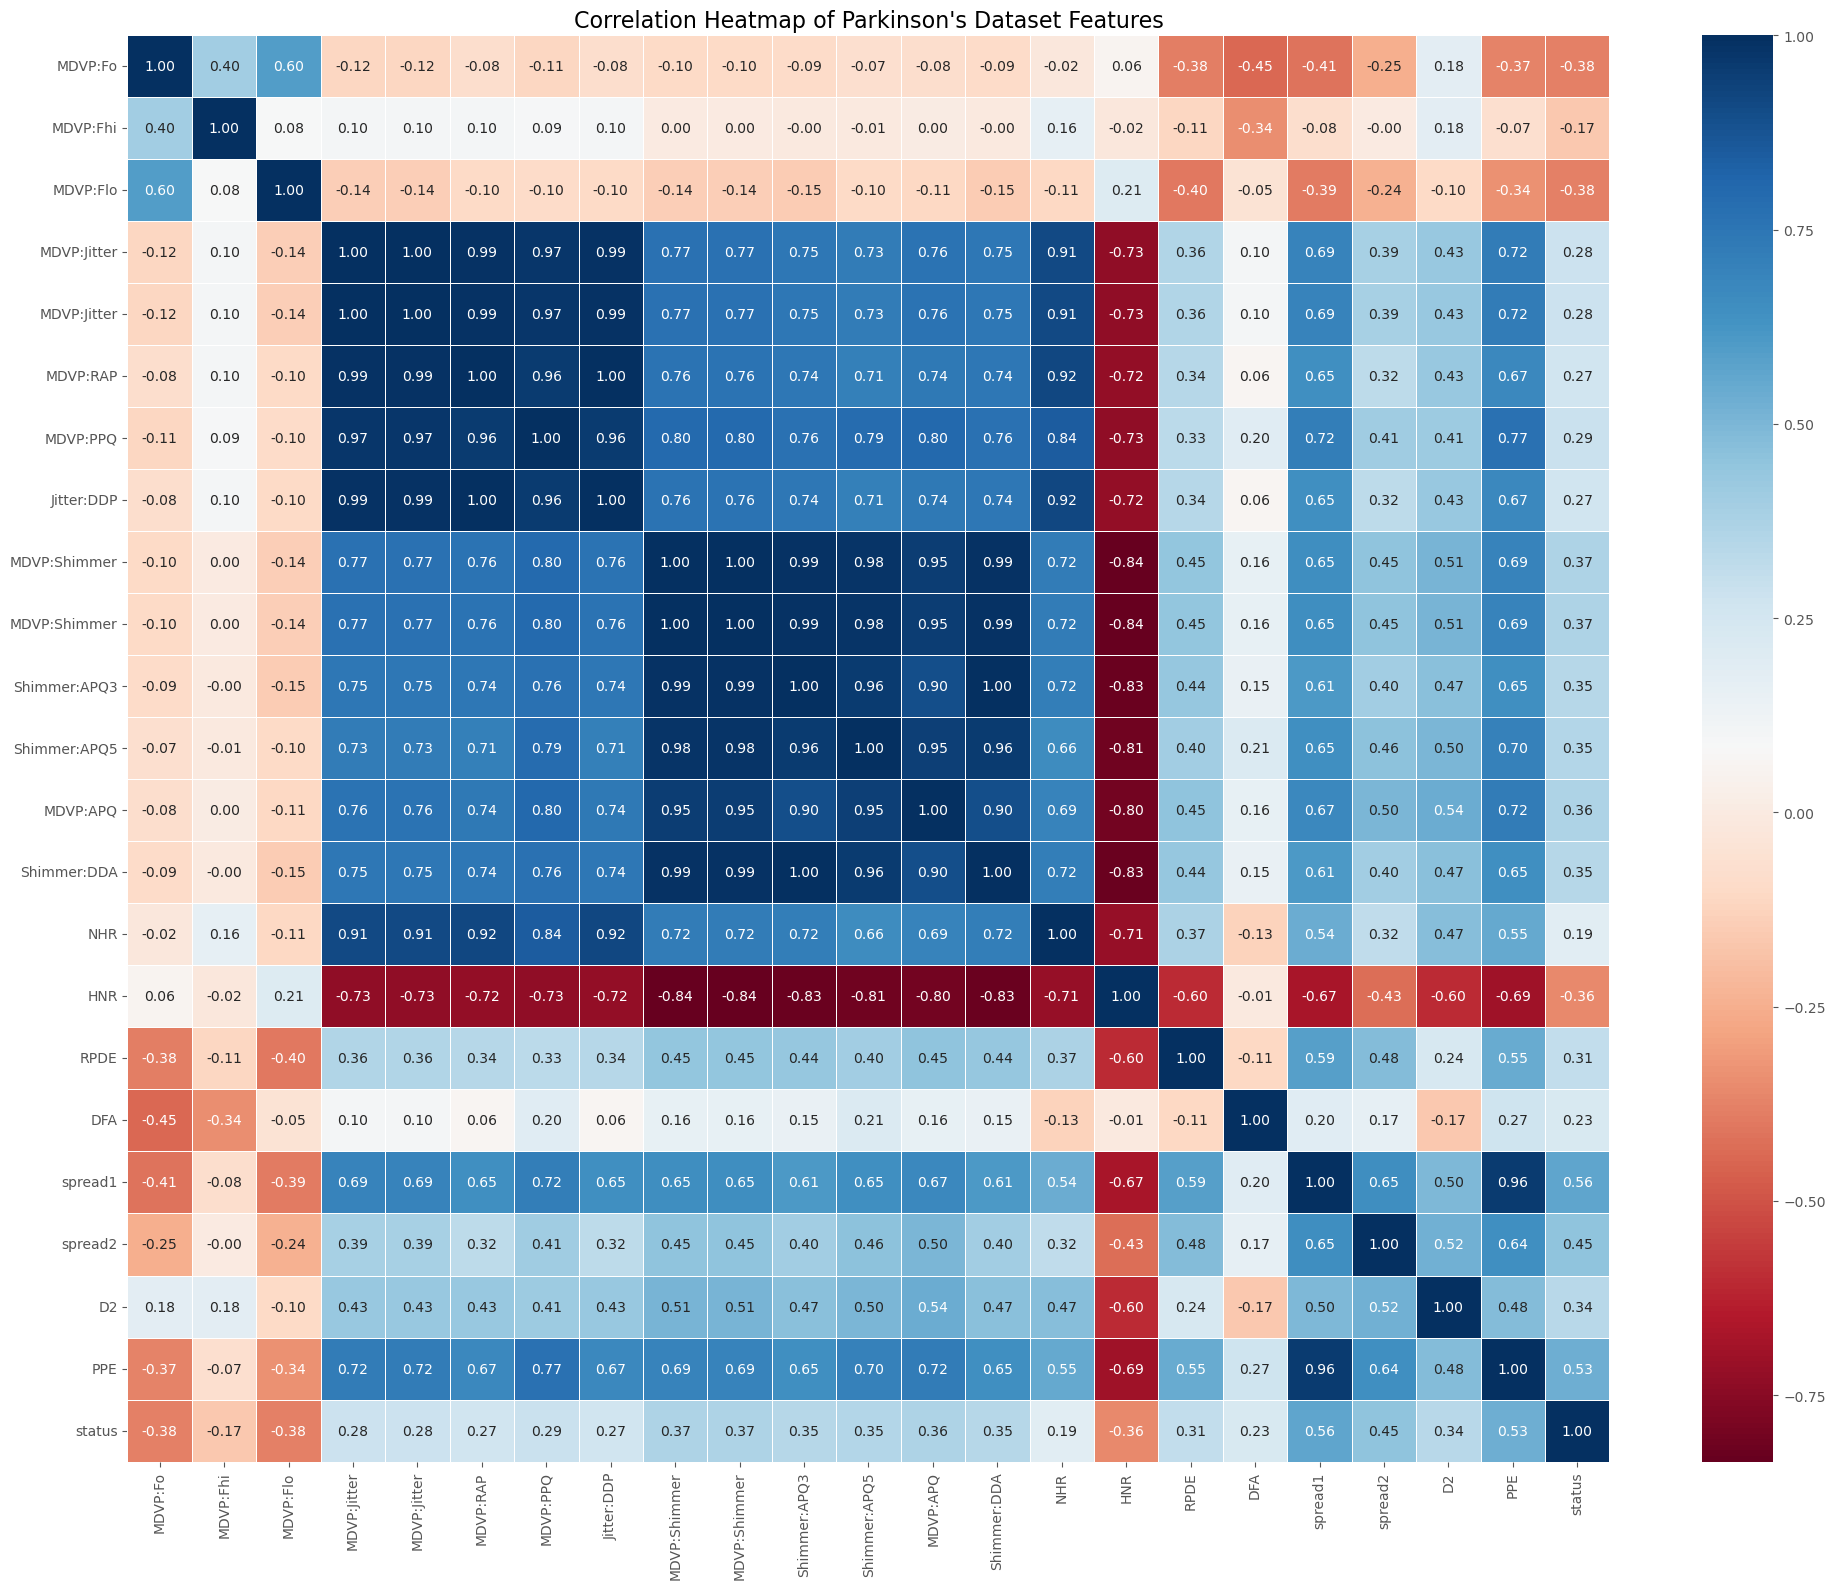

Correlation heatmap has been generated, saved, and displayed.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Fetch the dataset
parkinsons = fetch_ucirepo(id=174)
X = parkinsons.data.features
y = parkinsons.data.targets

# Combine features and target
df = pd.concat([X, y], axis=1)

# Set the style for all plots
plt.style.use('ggplot')
sns.set_palette("Set2")

# Correlation Heatmap
plt.figure(figsize=(20, 16))  # Increased figure size for better readability
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu', linewidths=0.5, cbar=True)
plt.title('Correlation Heatmap of Parkinson\'s Dataset Features', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Correlation heatmap has been generated, saved, and displayed.")

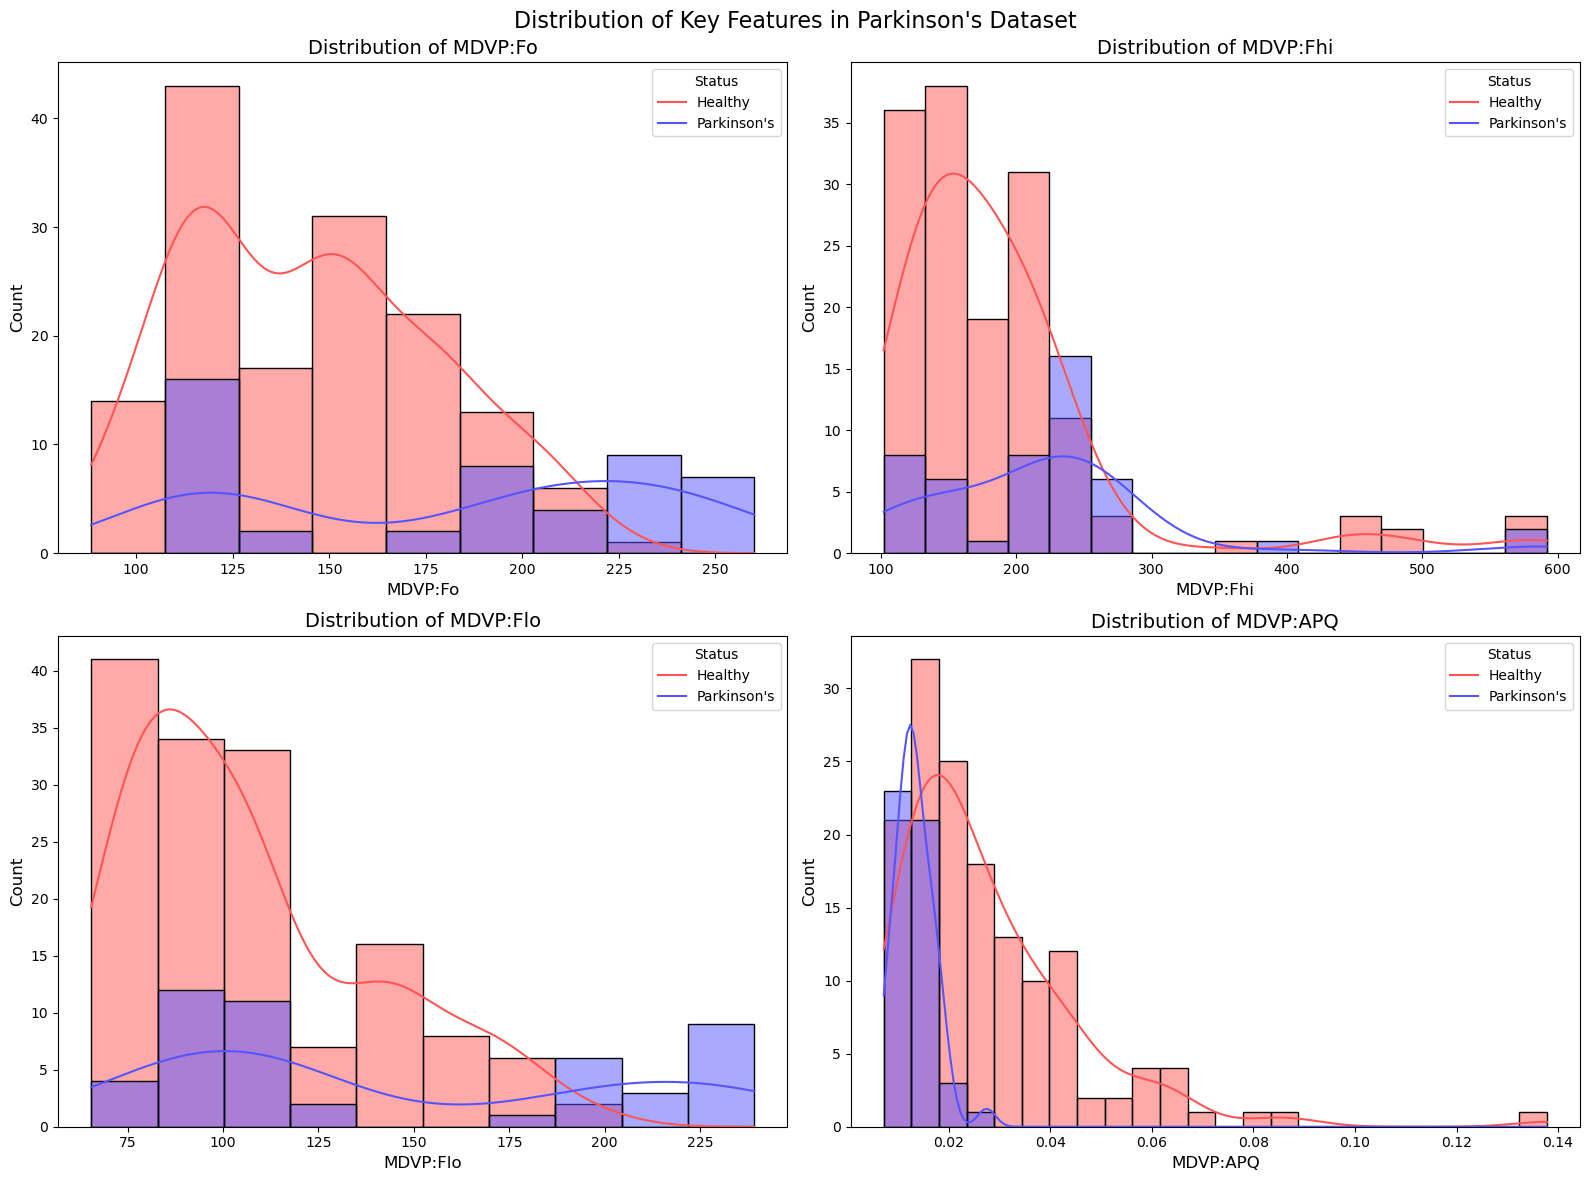

Visualizations have been generated, saved, and displayed.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Fetch the Parkinson's dataset
parkinsons = fetch_ucirepo(id=174)
X = parkinsons.data.features
y = parkinsons.data.targets

# Convert y to a 1D series
y = y['status'].squeeze()

# Combine features and target
df = pd.concat([X, pd.Series(y, name='status')], axis=1)

# Set up the plot style
plt.style.use('default')

# Visualize Distribution of Key Numerical Features
key_features = ['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:APQ']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Key Features in Parkinson\'s Dataset', fontsize=16)

# Update color palette to use 'PiYG' for differentiating classes
for i, feature in enumerate(key_features):
    row = i // 2
    col = i % 2
    
    sns.histplot(
        data=df, 
        x=feature, 
        hue='status', 
        kde=True, 
        ax=axes[row, col], 
        palette='seismic'
    )
    axes[row, col].set_title(f'Distribution of {feature}', fontsize=14)
    axes[row, col].set_xlabel(feature, fontsize=12)
    axes[row, col].set_ylabel('Count', fontsize=12)
    axes[row, col].legend(title='Status', labels=['Healthy', 'Parkinson\'s'])

plt.tight_layout()
plt.savefig('key_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations have been generated, saved, and displayed.")
